## Importação

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings('ignore')

clf = joblib.load('../models/classificador_cart_model.pkl')
reg = joblib.load('../models/regressor_model.pkl')

tlim1000victims = pd.read_csv('../results/unification/tlim1000_victims_all.csv')
tlim8000victims = pd.read_csv('../results/unification/tlim8000_victims_all.csv')
tlim1000knownmap = pd.read_csv('../results/unification/tlim1000_knownmap_all.csv')
tlim8000knownmap = pd.read_csv('../results/unification/tlim8000_knownmap_all.csv')


env_victims = pd.read_csv('../data/94x94_408v/env_victims.txt', sep=',', header=None, names=['linha', 'coluna'])
victims_data = pd.read_csv('../data/408v/data.csv')

victims_data['linha'] = env_victims['linha']
victims_data['coluna'] = env_victims['coluna']

tlim1000victims = tlim1000victims.rename(columns={'x': 'linha', 'y': 'coluna'})
tlim8000victims = tlim8000victims.rename(columns={'x': 'linha', 'y': 'coluna'})
victims_data = victims_data.rename(columns={'row': 'linha', 'col': 'coluna'})

tlim1000victims = tlim1000victims.merge(victims_data, on=['linha', 'coluna'], how='left')
tlim8000victims = tlim8000victims.merge(victims_data, on=['linha', 'coluna'], how='left')

Xtlim1000 = tlim1000victims.iloc[:, 2:12].values
Xtlim8000 = tlim8000victims.iloc[:, 2:12].values

tlim1000victims['tri'] = clf.predict(Xtlim1000)
tlim1000victims['sobr'] = reg.predict(Xtlim1000)
tlim8000victims['tri'] = clf.predict(Xtlim8000)
tlim8000victims['sobr'] = reg.predict(Xtlim8000)

## Elbow de Xtlim1000

  File "c:\Users\Pieri\anaconda3\envs\datascience\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Pieri\anaconda3\envs\datascience\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Pieri\anaconda3\envs\datascience\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Pieri\anaconda3\envs\datascience\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


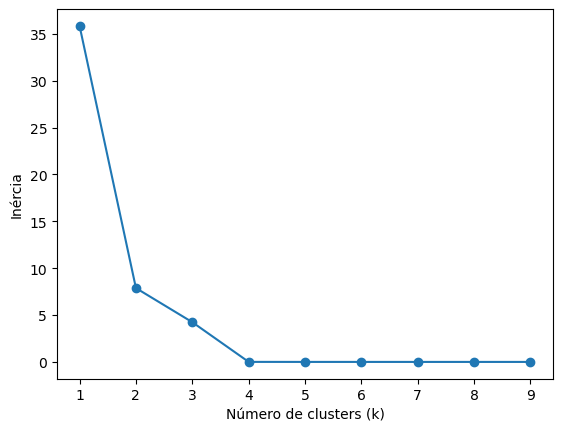

In [2]:
X = tlim1000victims[['tri', 'sobr']].values

inercias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

plt.plot(K, inercias, 'o-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.show()

## Elbow de Xtlim8000

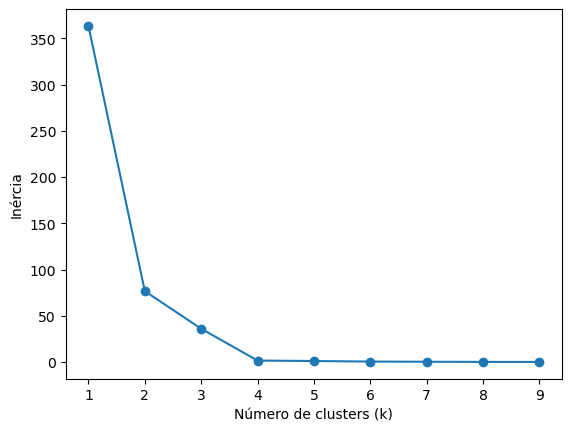

In [3]:
X = tlim8000victims[['tri', 'sobr']].values

inercias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

plt.plot(K, inercias, 'o-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.show()

## Clusterização de Xtlim1000

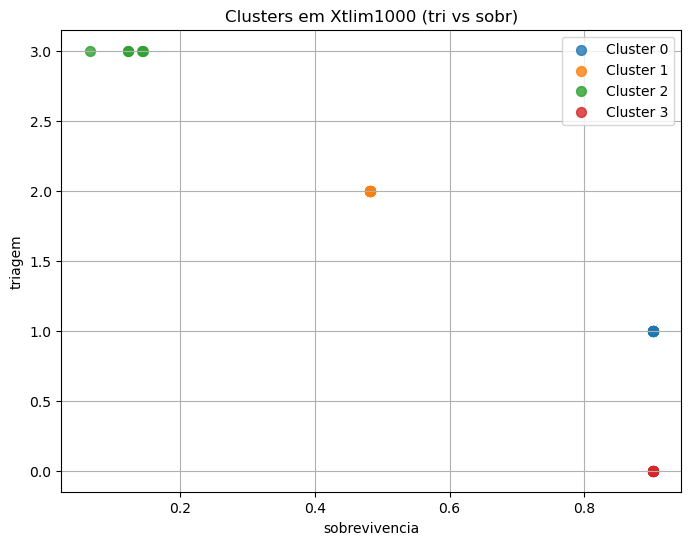

In [4]:
X = tlim1000victims[['sobr','tri']].values
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(tlim1000victims[['tri', 'sobr']])
kmeans = KMeans(n_clusters=4, random_state=42)
tlim1000victims['cluster'] = kmeans.fit_predict(dados_padronizados)
unique_clusters = sorted(tlim1000victims['cluster'].unique())

plt.figure(figsize=(8, 6))
for c in unique_clusters:
    sub = tlim1000victims[tlim1000victims['cluster'] == c]
    plt.scatter(sub['sobr'], sub['tri'], s=50, alpha=0.8, label=f'Cluster {c}')

plt.xlabel('sobrevivencia')
plt.ylabel('triagem')
plt.title('Clusters em Xtlim1000 (tri vs sobr)')
plt.legend()
plt.grid(True)
plt.show()

## Clusterização de Xtlim8000

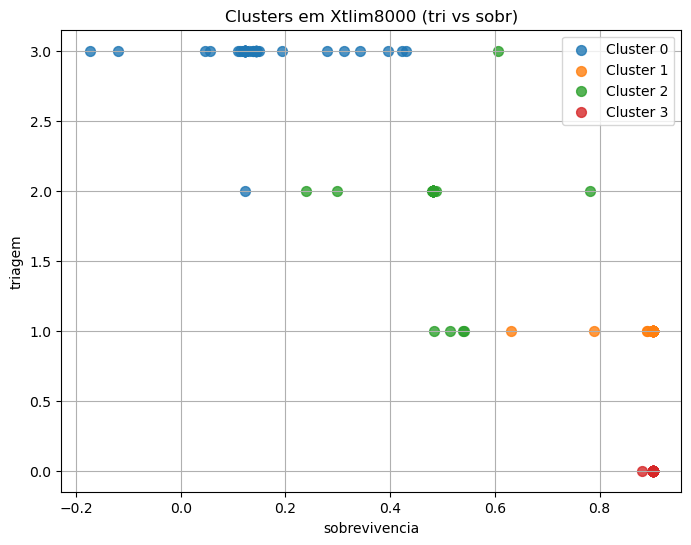

In [5]:
X = tlim8000victims[['sobr','tri']].values
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(tlim8000victims[['tri', 'sobr']])
kmeans = KMeans(n_clusters=4, random_state=42)
tlim8000victims['cluster'] = kmeans.fit_predict(dados_padronizados)
unique_clusters = sorted(tlim8000victims['cluster'].unique())

plt.figure(figsize=(8, 6))
for c in unique_clusters:
    sub = tlim8000victims[tlim8000victims['cluster'] == c]
    plt.scatter(sub['sobr'], sub['tri'], s=50, alpha=0.8, label=f'Cluster {c}')

plt.xlabel('sobrevivencia')
plt.ylabel('triagem')
plt.title('Clusters em Xtlim8000 (tri vs sobr)')
plt.legend()
plt.grid(True)
plt.show()

## Exportação dos clusters

In [19]:
def export_clusters(df, prefix):
    indexed_df = df.reset_index(names=['id'])
    required_cols = ['id','linha', 'coluna', 'sobr', 'tri']
    missing = [c for c in required_cols if c not in indexed_df.columns]
    if missing:
        raise ValueError(f"Colunas faltando no DataFrame: {missing}")

    for c in sorted(df['cluster'].unique()):
        sub = indexed_df[indexed_df['cluster'] == c]
        out = sub[['id', 'linha', 'coluna', 'sobr', 'tri']].copy()
        out.columns = ['id', 'x', 'y', 'sobr', 'tri']  # ordem/nomes exigidos
        # nomeia arquivos como prefix_cluster1.txt, prefix_cluster2.txt, ...
        fname = f"../results/clustering/{prefix}_cluster{int(c) + 1}.csv"
        out.to_csv(fname, index=False)
        print(f"Exportado {len(out)} linhas para {fname}")

# Exporta para os dois dataframes já clusterizados
export_clusters(tlim1000victims, 'tlim1000')
export_clusters(tlim8000victims, 'tlim8000')

Exportado 9 linhas para ../results/clustering/tlim1000_cluster1.csv
Exportado 9 linhas para ../results/clustering/tlim1000_cluster2.csv
Exportado 5 linhas para ../results/clustering/tlim1000_cluster3.csv
Exportado 8 linhas para ../results/clustering/tlim1000_cluster4.csv
Exportado 67 linhas para ../results/clustering/tlim8000_cluster1.csv
Exportado 69 linhas para ../results/clustering/tlim8000_cluster2.csv
Exportado 85 linhas para ../results/clustering/tlim8000_cluster3.csv
Exportado 65 linhas para ../results/clustering/tlim8000_cluster4.csv
